In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import utils
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from keras import backend as K
from keras.callbacks import EarlyStopping
%config InlineBackend.figure_format = 'retina'
import pandas as pd
%matplotlib inline
from keras import activations, initializers
from keras.layers import Layer
import tensorflow as tf
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import sys
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow_probability.python.layers import DistributionLambda
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline

Using TensorFlow backend.


In [2]:
noise = 1
def neg_log_likelihood_with_dist(y_true, y_pred, sigma = noise):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

In [3]:
def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma
  
def log_mixture_prior_prob(w):
    comp_1_dist = tf.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tf.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))
  
# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

In [4]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def  posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential(
        [tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
])

In [5]:
df, scaler, continuous_cols = utils.xform_data(pd.read_csv('task.csv'))

In [6]:
permuts = utils.get_permutations(pd.read_csv('task.csv'), 50)

In [7]:
x_train = df.drop(['log_Target'], axis = 1)
y_train = df['log_Target']

In [8]:
n_epochs = 25000
lr = 5e-3
batch_size = x_train.shape[0]

In [9]:
def implement_wape(ys, preds):
    numer8 = np.sum(np.abs(np.array(ys) - np.array(preds)))
    w = (numer8)/np.sum(np.abs(ys))
    return w

In [10]:
train_size = len(x_train)
X = []
y = []
X_val = []
y_val = []

space = {'choice': hp.choice('num_layers',
                             [{'layers':'two', },
                              {'layers':'three', 
                               'units3': hp.choice('units3', [32, 64])
                              }
                             ]),
         'units1': hp.choice('units1', [16, 32, 64]),
         'units2': hp.choice('units2', [16, 32, 64]),
         'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
        }

def f_nn(params):   

    print ('Params testing: ', params)
    model_in = Input(shape=(x_train.shape[1],))
    x = tfp.layers.DenseVariational(int('{}'.format(params['units1'])), posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
    x = tfp.layers.DenseVariational(int('{}'.format(params['units2'])), posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    
    if params['choice']['layers']== 'three':
        x = tfp.layers.DenseVariational(int('{}'.format(params['choice']['units3'])), posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
        x = LeakyReLU(0.1)(x) 
    
    model_out_loc = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out_scale = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[0],
                                                        scale=1e-7 + tf.math.softplus(1e-3 * t[1])))([model_out_loc,
                                                                                                      model_out_scale])
    model = Model(model_in, model_out)
    model.compile(loss=neg_log_likelihood_with_dist, optimizer=params['optimizer'], metrics=['mse'])
    #early_stop = EarlyStopping(monitor='mse', min_delta = 0, patience=1000, mode='auto')
    model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, verbose = 1)#, callbacks = [early_stop])

    y_pred_list = []
    for i in range(len(x_train)):
        tensor = tf.constant([x_train.iloc[i]], dtype='float32')
        pred_list = []
        for j in range(500):
            y_pred = model.predict(tensor)
            pred_list.append(y_pred)
        y_pred_list.append(pred_list)

    y_means = np.mean(y_pred_list, axis = 1)
    y_means = y_means.reshape(len(x_train),)
    wape = implement_wape(y_means, y_train)
    print('WAPE: {}' .format(wape))
    return wape
    
#trials = Trials()
#best = fmin(f_nn, space, algo=tpe.suggest, max_evals=5, trials=trials)
#print('best: ', best)

In [11]:
def build_model(train_size):
    model_in = Input(shape=(x_train.shape[1],))
    x = tfp.layers.DenseVariational(32, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
    x = tfp.layers.DenseVariational(32, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    x = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out_loc = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out_scale = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[0],
                                                        scale=1e-7 + tf.math.softplus(1e-3 * t[1])))([model_out_loc,
                                                        model_out_scale])
    model = Model(model_in, model_out)
    return model

model = build_model(len(x_train))
model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
dense_variational (DenseVariati (None, 32)           3360        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32)           0           dense_variational[0][0]          
__________________________________________________________________________________________________
dense_variational_1 (DenseVaria (None, 32)           3168        leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [12]:
#early_stop = EarlyStopping(monitor='mse', min_delta = 0, patience=1000, mode='auto')
#hist = model.fit(x_train, y_train, epochs = 10000)#, callbacks = [early_stop] )

In [13]:
model.load_weights('bnn_weights')

In [28]:
data_to_test = permuts

In [29]:
import tqdm
y_pred_list = []
for i in tqdm.tqdm(range(len(data_to_test))):
    tensor = tf.constant([data_to_test.iloc[i]], dtype='float32')
    pred_list = []
    for j in range(100):
        y_pred = model.predict(tensor)
        pred_list.append(y_pred)
    y_pred_list.append(pred_list)

100%|██████████| 50/50 [05:52<00:00,  7.06s/it]


In [30]:
y_means = np.mean(y_pred_list, axis = 1)
y_sigmas = np.std(y_pred_list, axis = 1)
y_sigmas = y_sigmas.reshape(len(data_to_test),)
y_means = y_means.reshape(len(data_to_test),)

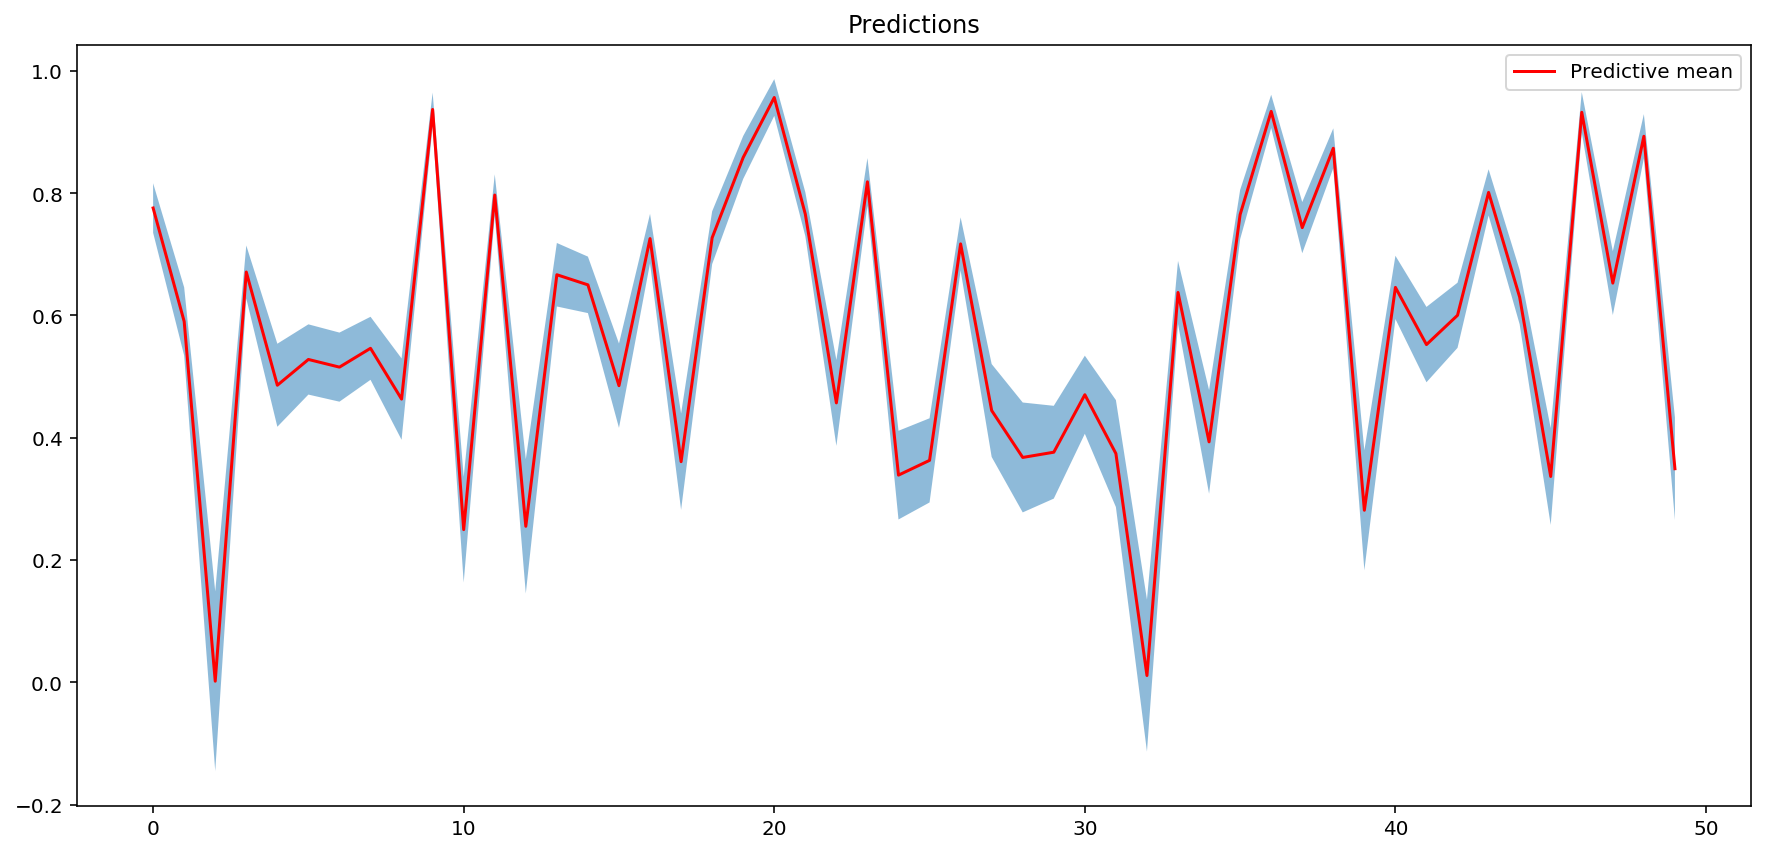

In [33]:
idx = range(len(data_to_test))
plt.figure(figsize = (15, 7))
#plt.plot(idx, y_train[:len(data_to_test)], 'black', marker = '+')
plt.plot(idx, y_means[:len(data_to_test)], 'r-', label='Predictive mean');
plt.fill_between(idx, y_means[:len(data_to_test)] + 3 * y_sigmas[:len(data_to_test)],
                 y_means[:len(data_to_test)] - 3 * y_sigmas[:len(data_to_test)], alpha=0.5)
plt.legend()
plt.title('Predictions');

In [77]:
scaled_t = scaler.inverse_transform(t)

In [79]:
np.exp(scaled_t[0][-1:])

array([7106.98011568])

In [36]:
#implement_wape(y_train, y_means)

0.0984883458590431